## Импорты

In [26]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [27]:
#!g1.1
SEED = 1234
ROOT = '.data'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [28]:
#!g1.1

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [29]:
#!g1.1
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [30]:
#!g1.1
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [31]:
#!g1.1
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Модель

In [65]:
#!g1.1
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [66]:
#!g1.1
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [67]:
#!g1.1
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [68]:
#!g1.1
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [69]:
#!g1.1
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [320]:
#!g1.1
class LeNet(nn.Module):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=256, out_features=120)
        self.lin2 = nn.Linear(in_features=120, out_features=84)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x
    
    def init_weights(self, init_mode):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init_mode == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(m.weight, mode='fan_in',
                                             nonlinearity='relu')
                elif init_mode == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight, mode='fan_in',
                                            nonlinearity='relu')
                elif init_mode == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                elif init_mode == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                else:
                    m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()

class LeNet_bn(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=256, out_features=120)
        self.bn3 = nn.BatchNorm1d(120)
        self.lin2 = nn.Linear(in_features=120, out_features=84)
        self.bn4 = nn.BatchNorm1d(84)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        x = self.bn3(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.bn4(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x

class LeNet_do(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []
        self.do_p = 0.25
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.do1 = nn.Dropout(self.do_p)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.do2 = nn.Dropout(self.do_p)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=256, out_features=120)
        self.do3 = nn.Dropout(self.do_p)
        self.lin2 = nn.Linear(in_features=120, out_features=84)
        self.do4 = nn.Dropout(self.do_p)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.do1(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.do2(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        x = self.do3(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.do4(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x
    
class LeNet_wide(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=512, out_features=240)
        self.lin2 = nn.Linear(in_features=240, out_features=84)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x
        
class LeNet_narrow(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=160, out_features=100)
        self.lin2 = nn.Linear(in_features=100, out_features=84)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x
    

OUTPUT_DIM = 10
model = LeNet_wide(OUTPUT_DIM)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 149,202 trainable parameters


In [321]:
#!g1.1
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [322]:
#!g1.1
EPOCHS = 1

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LeNet_.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

KeyboardInterrupt: 

In [ ]:
#!g1.1
torch.cat(act).detach().numpy()

In [278]:
#!g1.1
res = torch.FloatTensor()
for a in model.activations:
    res = torch.cat([res, torch.flatten(a, 1)])

NameError: name 'activations' is not defined

In [260]:
#!g1.1
model.load_state_dict(torch.load('LeNet.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.301 | Test Acc: 11.36%


In [261]:
#!g1.1
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [262]:
#!g1.1
images, labels, probs = get_predictions(model, test_iterator, device)

In [20]:
#!g1.1
pred_labels = torch.argmax(probs, 1)

In [21]:
#!g1.1
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

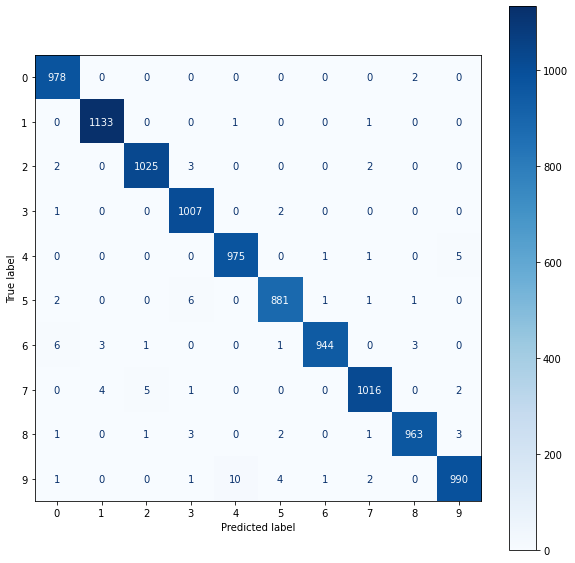

In [28]:
#!g1.1
plot_confusion_matrix(labels, pred_labels)

In [22]:
#!g1.1
corrects = torch.eq(labels, pred_labels)

In [23]:
#!g1.1
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [24]:
#!g1.1
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

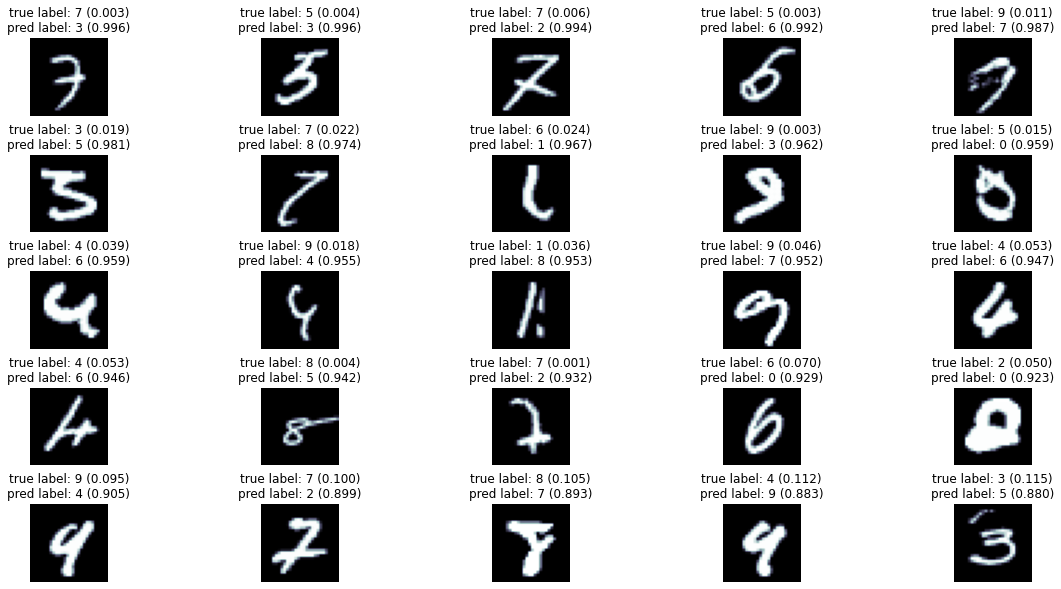

In [25]:
#!g1.1
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)